In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import plotly.express as px
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data=pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
null_values = data.isnull().sum()

In [ ]:
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

There are 0 missing values for review and 0 missing values for sentiment.


In [ ]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [ ]:
review = data['review']
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [ ]:
data.drop_duplicates(inplace = True)

In [ ]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


In [ ]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()


In [ ]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot",
           "'cause": "because", "could've": "could have", "couldn't": "could not",
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
           "might've": "might have","mightn't": "might not","mightn't've": "might not have",
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
           "she's": "she is", "should've": "should have", "shouldn't": "should not",
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is",
           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
           "here's": "here is","they'd": "they would", "they'd've": "they would have",
           "they'll": "they will", "they'll've": "they will have", "they're": "they are",
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
           "we're": "we are", "we've": "we have", "weren't": "were not",
           "what'll": "what will", "what'll've": "what will have","what're": "what are",
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
           "you're": "you are", "you've": "you have" }

In [ ]:
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()])
    return text

In [ ]:
data_copy = data.copy()

In [ ]:
data['review']=data['review'].apply(clean_text,lemmatize = True)

<ipython-input-16-c34580d73e8b>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #remove html tags


In [ ]:
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [ ]:
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1


<ipython-input-21-b7b62e4f103a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x='sentiment', palette=['green', 'red'], order=[1, 0])


Text(0.5, 1.0, 'Target count for IMDB reviews')

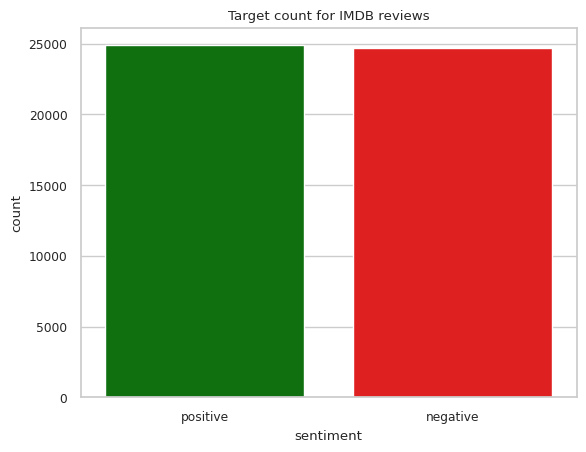

In [ ]:
sns.set(style="whitegrid", font_scale=.8)
ax = sns.countplot(data=data, x='sentiment', palette=['green', 'red'], order=[1, 0])
plt.xticks(ticks=np.arange(2), labels=['positive', 'negative'])
plt.title('Target count for IMDB reviews')


In [ ]:
print('Positive reviews are', (round(data['sentiment'].value_counts()[0])),'i.e.', round(data['sentiment'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Negative reviews are', (round(data['sentiment'].value_counts()[1])),'i.e.',round(data['sentiment'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Positive reviews are 24698 i.e. 49.81 % of the dataset
Negative reviews are 24884 i.e. 50.19 % of the dataset


In [ ]:
positive_data = data[data.sentiment == 1]['review']
negative_data = data[data.sentiment == 0]['review']

<ipython-input-24-644cadbc1484>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word, ax=ax1,color='green')
<ipython-input-24-644cadbc1484>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,ax=ax2,color='red')


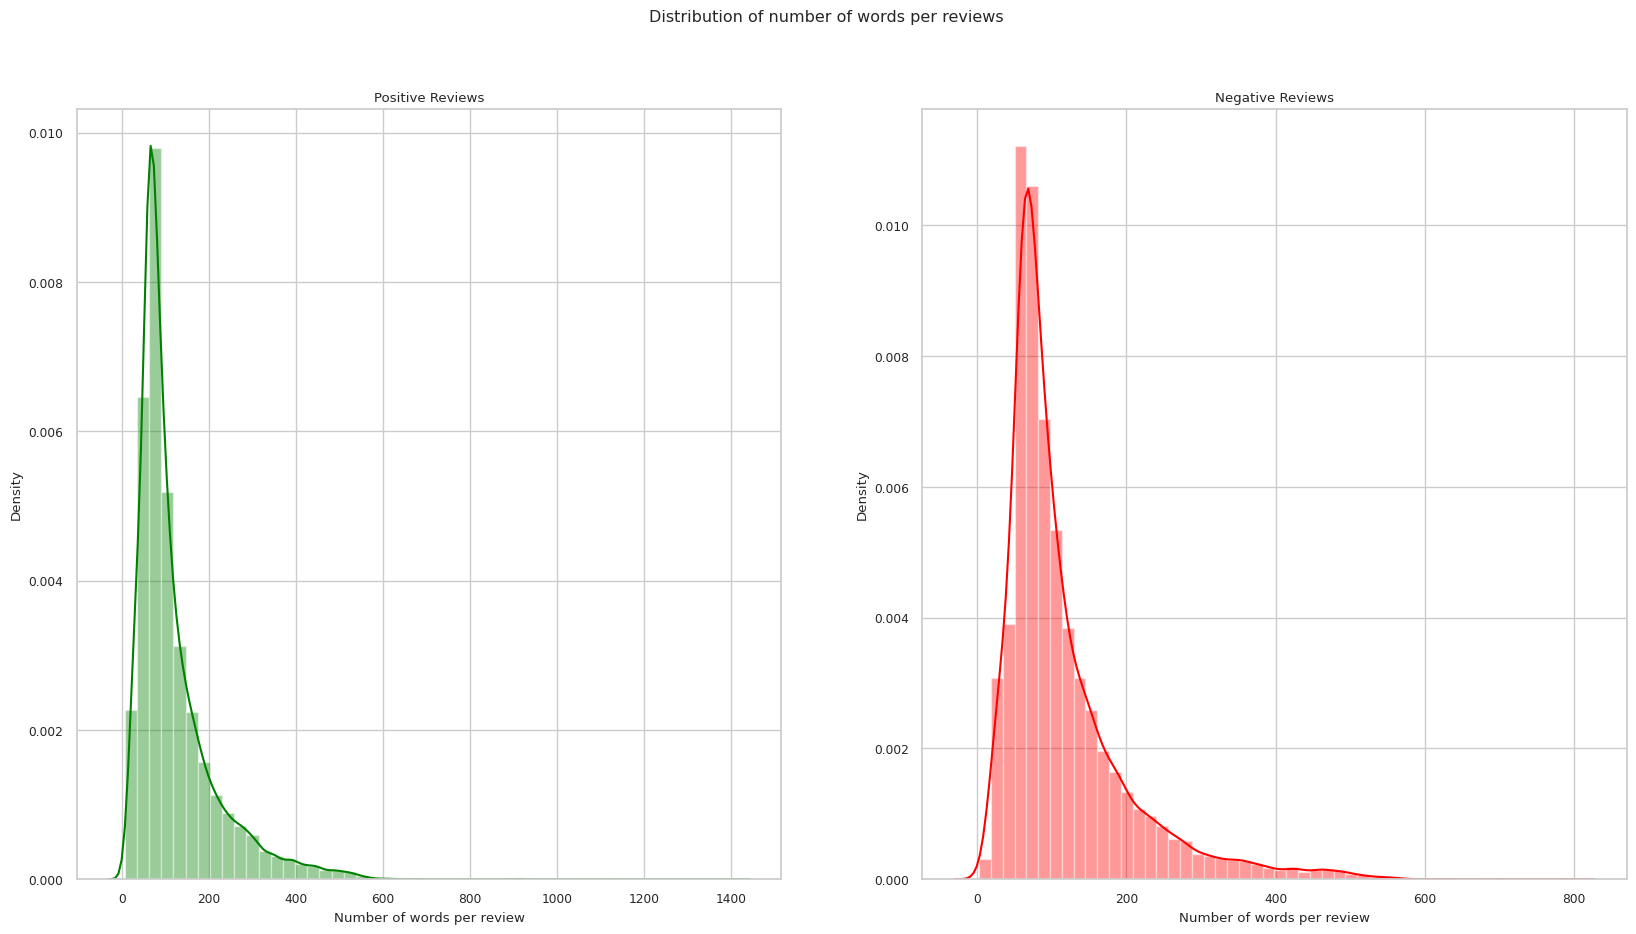

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

In [ ]:
def get_words(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
word = get_words(data.review)

In [28]:
from collections import Counter
counter = Counter(word)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['word','count'])
most_common

,word,count
0,movie,100605
1,film,91130
2,one,53525
3,like,39746
4,time,30091
5,would,30037
6,good,28905
7,character,27801
8,story,24600
9,even,24440


In [29]:
px.bar(most_common,x='count',y='word',title='Common Words in Positive Label',color='word')

In [30]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review)
    sum_words = bag_of_words.sum(axis=0)
    sum_words = np.array(sum_words)[0].tolist()
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<ipython-input-31-fbf6c7d97d7b>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-31-fbf6c7d97d7b>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




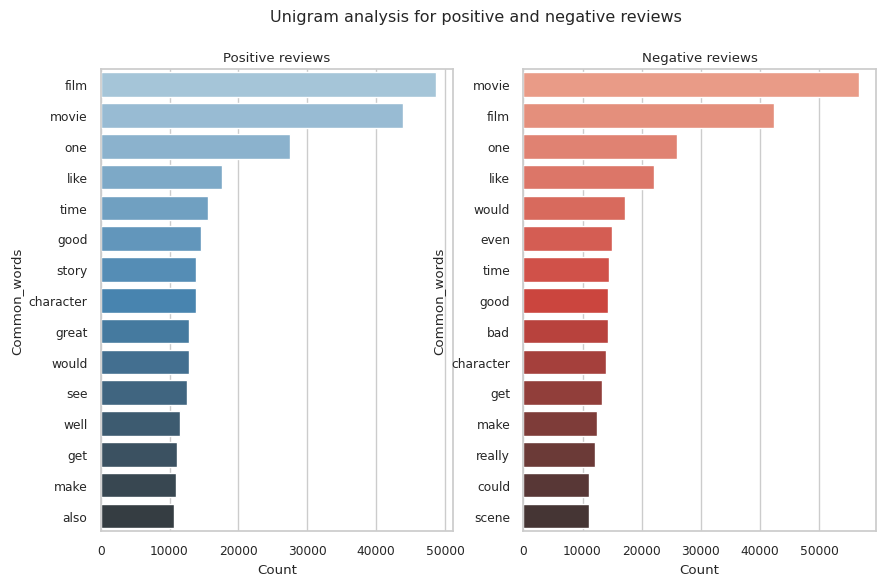

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
uni_positive = get_ngrams(positive_data,15,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1,palette="Blues_d")
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(negative_data,15,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2,palette="Reds_d")
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()

<ipython-input-32-243a659ea9a4>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-32-243a659ea9a4>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




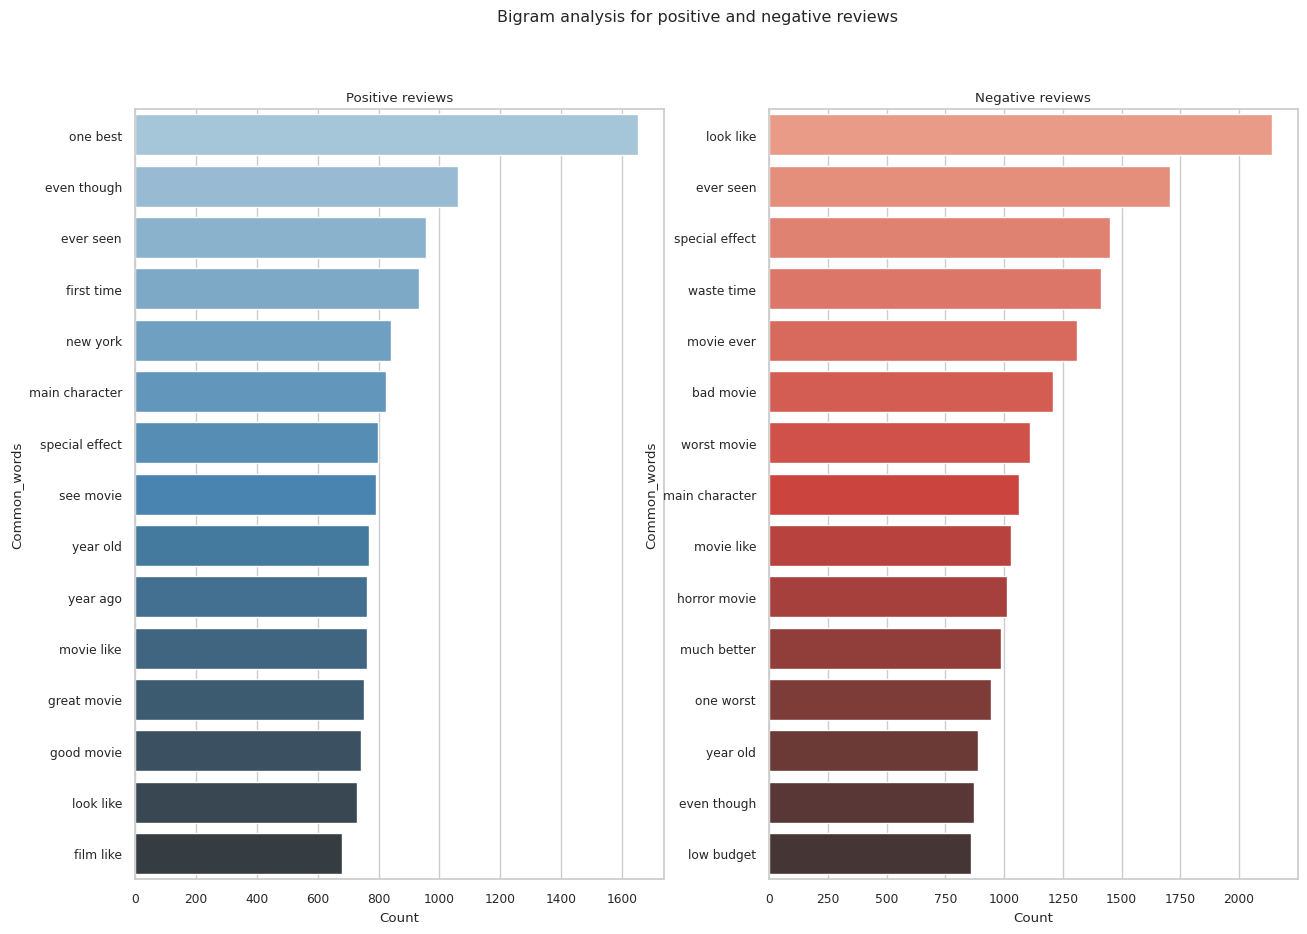

In [32]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,10))
bi_positive = get_ngrams(positive_data,15,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1,palette="Blues_d")
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(negative_data,15,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2,palette="Reds_d")
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

<ipython-input-33-1b1a5017a844>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-33-1b1a5017a844>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




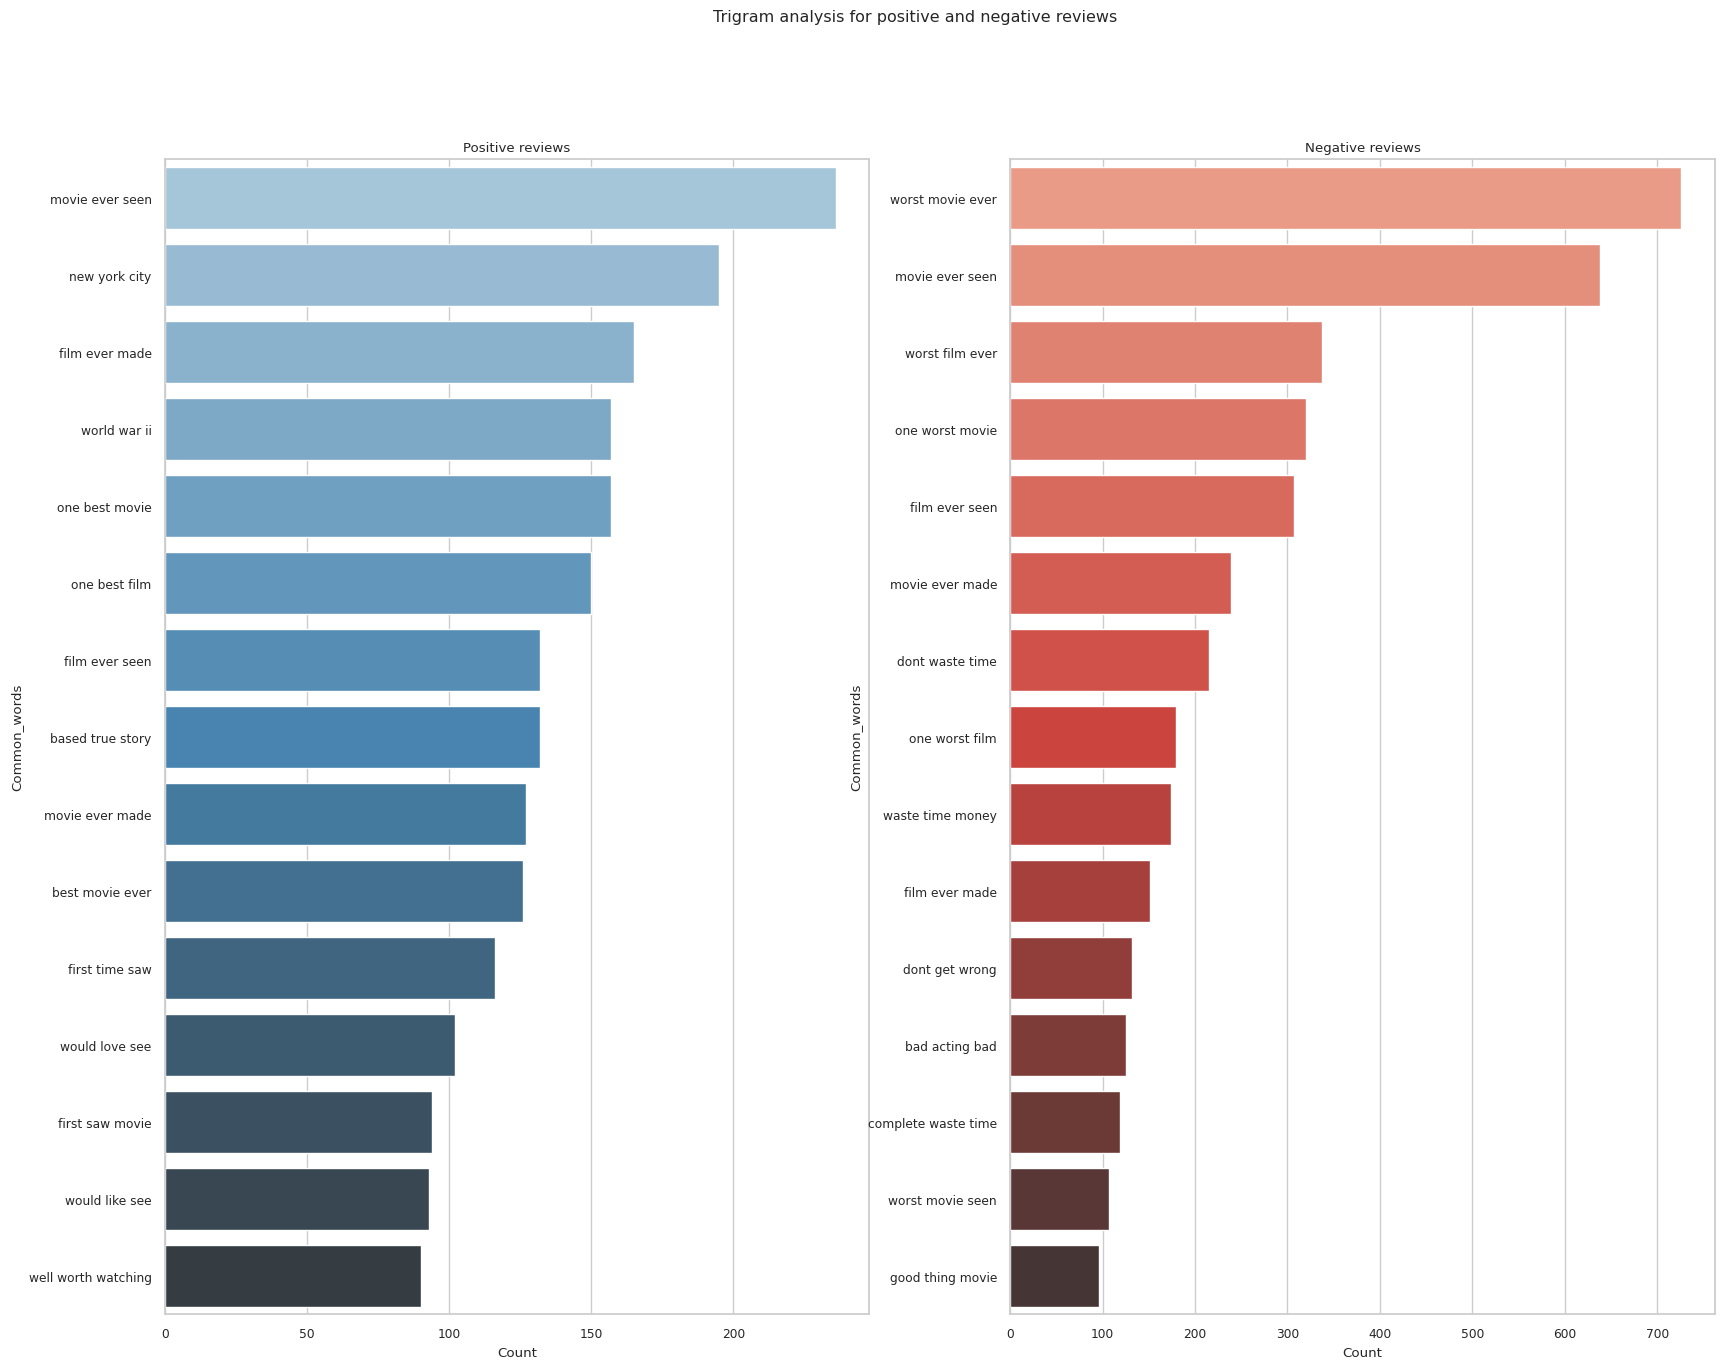

In [33]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,15))
tri_positive = get_ngrams(positive_data,15,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1,palette="Blues_d")
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(negative_data,15,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2,palette="Reds_d")
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')
plt.show()

In [34]:
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [35]:
tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

Logistic Regression



In [36]:
lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))


Logistic Regression Accuracy : 89.05%


In [37]:
print(confusion_matrix(ytest, p1))
print("\n")
print(classification_report(ytest, p1))

[[4316  623]
 [ 463 4515]]


              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4939
           1       0.88      0.91      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



Naive Bayes

In [38]:
mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
p2=mnb.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))

Multinomial Naive Bayes Classifier Accuracy : 86.79%


In [39]:
print(confusion_matrix(ytest, p2))
print("\n")
print(classification_report(ytest, p2))

[[4314  625]
 [ 685 4293]]


              precision    recall  f1-score   support

           0       0.86      0.87      0.87      4939
           1       0.87      0.86      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



Linear SVM

In [40]:
linear_svc = LinearSVC(penalty='l2',loss = 'hinge')
linear_svc.fit(Xtrain_tfidf,ytrain)
p3=linear_svc.predict(Xtest_tfidf)
s3=accuracy_score(ytest,p3)
print("Linear Support Vector Classifier Accuracy :", "{:.2f}%".format(100*s3))

Linear Support Vector Classifier Accuracy : 89.57%


In [41]:
print(confusion_matrix(ytest, p3))
print("\n")
print(classification_report(ytest, p3))

[[4354  585]
 [ 449 4529]]


              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4939
           1       0.89      0.91      0.90      4978

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



Deep Learning Models

In [42]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))

  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [43]:
data_copy['review']=data_copy['review'].apply(clean_text,lemmatize = False)
#converting target variable to numerical value
data_copy.sentiment = [ 1 if each == "positive" else 0 for each in data_copy.sentiment]
train, test= train_test_split(data_copy, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

<ipython-input-13-c34580d73e8b>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



LSTM

In [44]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  136566


In [45]:
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [46]:
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1406


In [47]:
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 293


In [48]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.51 % of data


In [49]:
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [50]:
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,test_size=0.2,random_state=10)

In [51]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    r = model.fit(Xtrain,ytrain,
                  validation_data = (Xval,yval),
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs

In [52]:
D = 64
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 293)]             0         
                                                                 
 embedding (Embedding)       (None, 293, 64)           8740288   
                                                                 
 batch_normalization (Batch  (None, 293, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 293, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 289, 32)           10272     
                                                                 
 dropout_1 (Dropout)         (None, 289, 32)           0         
                                                             

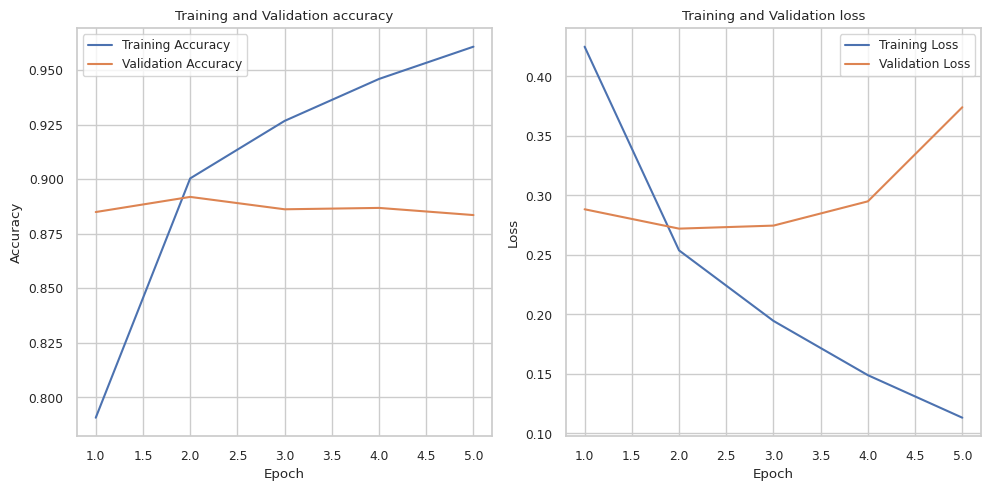

In [53]:
plotLearningCurve(r,n_epochs)

In [54]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 [==============================] - 4s 12ms/step - loss: 0.3971 - accuracy: 0.8771
{'loss': 0.39708641171455383, 'accuracy': 0.8770797848701477}


In [56]:
ypred = model.predict(pad_test)
ypred = ypred>0.5
print(confusion_matrix(ytest, ypred))
print("\n")
print(classification_report(ytest, ypred))

310/310 [==============================] - 4s 13ms/step
[[4174  765]
 [ 454 4524]]


              precision    recall  f1-score   support

           0       0.90      0.85      0.87      4939
           1       0.86      0.91      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917

